[PHOENIX model ftp address](ftp://phoenix.astro.physik.uni-goettingen.de//v1.0/SpecIntFITS/PHOENIX-ACES-AGSS-COND-SPECINT-2011/Z-0.0/)

[Some results on alkali metals in hot Jupiters](http://www.exoclimes.com/news/recent-results/a-survey-of-alkali-line-absorption-in-exoplanetary-atmospheres/)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import batman

In [25]:
from astropy.utils.data import download_file

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelength_path = download_file(wavelength_url, cache=True, timeout=30)
wavelengths_vacuum = fits.getdata(wavelength_path)

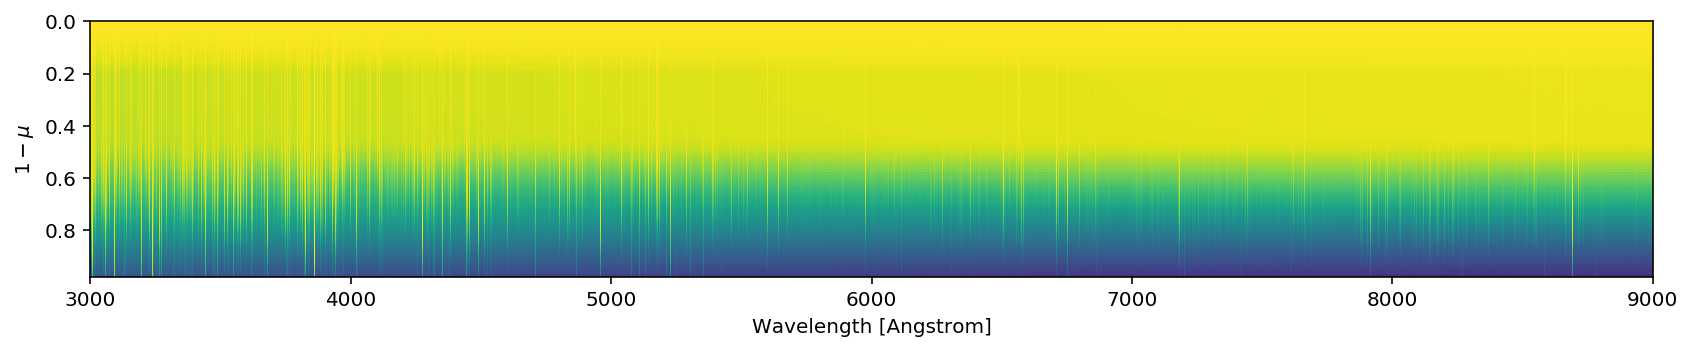

In [341]:
from astropy.io import fits

mu = fits.open("data/lte04800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")[1].data
mu_vs_lam = fits.getdata("data/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")
mu_vs_lam /= mu_vs_lam.max(axis=0)

header = fits.getheader("data/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")

wavelengths = header['CRVAL1'] + np.arange(0, mu_vs_lam.shape[1]) * header['CDELT1']

one_minus_mu = 1 - mu
extent = [wavelengths.min(), wavelengths.max(), 
          one_minus_mu.max(), one_minus_mu.min()]
fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(np.log(mu_vs_lam), extent=extent, origin='lower', 
          interpolation='nearest')
ax.set_xlim([3000, 9000])
# ax.set_xlim([6560, 6570])
ax.set_aspect(1000)
# ax.set_aspect(10)
ax.set(xlabel='Wavelength [Angstrom]', ylabel='$1 - \mu$');

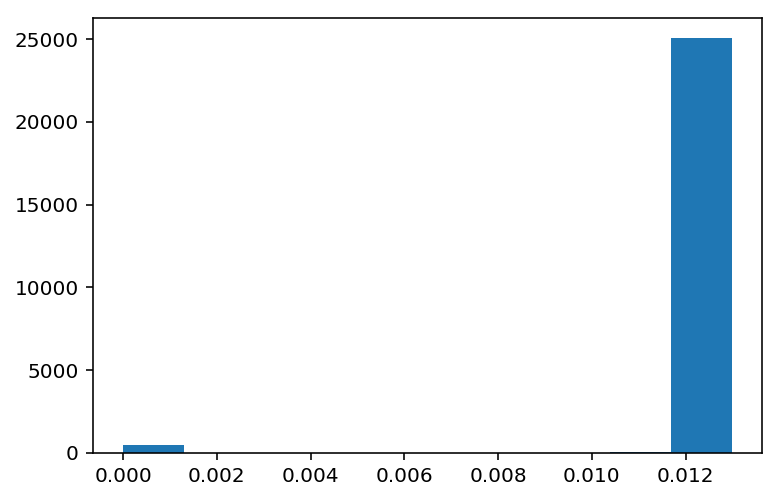

In [220]:
plt.hist(np.mean(np.diff(mu_vs_lam, axis=0), axis=0));

In [664]:
na_D = [5896, 5890]
ca_HK = [3968, 3934]
k_1 = 7664.8991
ref_lambda = 5010
ca_1 = 6122.219

fe_E = 5270
wl_names = ['continuum', 'Na D1', 'Na D2', 'Ca H', 
            'Ca K', 'K I', "Ca I"]#, 'Fe E']
test_wavelengths = [ref_lambda, na_D[0], na_D[1], ca_HK[0], 
                    ca_HK[1], k_1, ca_1]#, fe_E]
index_ref = np.argmin(np.abs(wavelengths - ref_lambda))
index_d1 = np.argmin(np.abs(wavelengths - na_d[0]))
index_d2 = np.argmin(np.abs(wavelengths - na_d[1]))

In [665]:
def wavelength_to_quadratic(wavelength):
    mu_lower_limit = 0.05
    
    limit_mu = mu > mu_lower_limit
    
    quad_params = np.polyfit(mu[limit_mu], mu_vs_lam[limit_mu, ind], 2)
    return quad_params[::-1]

In [666]:
from scipy.optimize import fmin_powell, fmin_slsqp, fmin_l_bfgs_b

mu_lower_limit = 0.06

In [667]:
def nonlinear(p, mu):
    c_1, c_2, c_3, c_4 = p
    return (1 - c_1*(1 - mu**0.5) - c_2 * (1-mu) - 
            c_3 * (1 - mu**1.5) - c_4 * (1 - mu**2))

def chi2_nl(p, mu, wl):
    limit_mu = mu > mu_lower_limit
    ind = np.argmin(np.abs(wavelengths - wl))
    intensity = mu_vs_lam[limit_mu, ind]
    return np.sum((nonlinear(p, mu[limit_mu]) - intensity)**2 / 0.01**2)

def wavelength_to_nonlinear(wavelength):
    return fmin_slsqp(chi2_nl, [0.5, -0.1, 0.1, -0.1], 
                      args=(mu, wavelength), disp=0)

def chi2_optical(p, mu):
    limit_mu = mu > mu_lower_limit
    intensity = mu_vs_lam.mean(1)
    chi = np.sum((nonlinear(p, mu[limit_mu]) - intensity[limit_mu])**2 / 0.01**2)
    return chi

def optical_to_nonlinear():
    return fmin_slsqp(chi2_optical, [0.5, -0.1, 0.1, -0.1], 
                      args=(mu, ), disp=0)

In [668]:
def logarithmic(p, mu):
    c_1, c_2 = p
    return (1 - c_1*(1-mu) - c_2 * mu * np.log(mu))

def chi2_log(p, mu, wl):
    limit_mu = mu > mu_lower_limit
    ind = np.argmin(np.abs(wavelengths - wl))
    intensity = mu_vs_lam[limit_mu, ind]
    return np.sum((logarithmic(p, mu[limit_mu]) - intensity)**2 /0.01**2)

def wavelength_to_log(wavelength):
    return fmin_l_bfgs_b(chi2_log, [1, 1], args=(mu, wavelength), 
                         approx_grad=True, bounds=[[-1, 2], [-1, 2]], disp=0)[0]

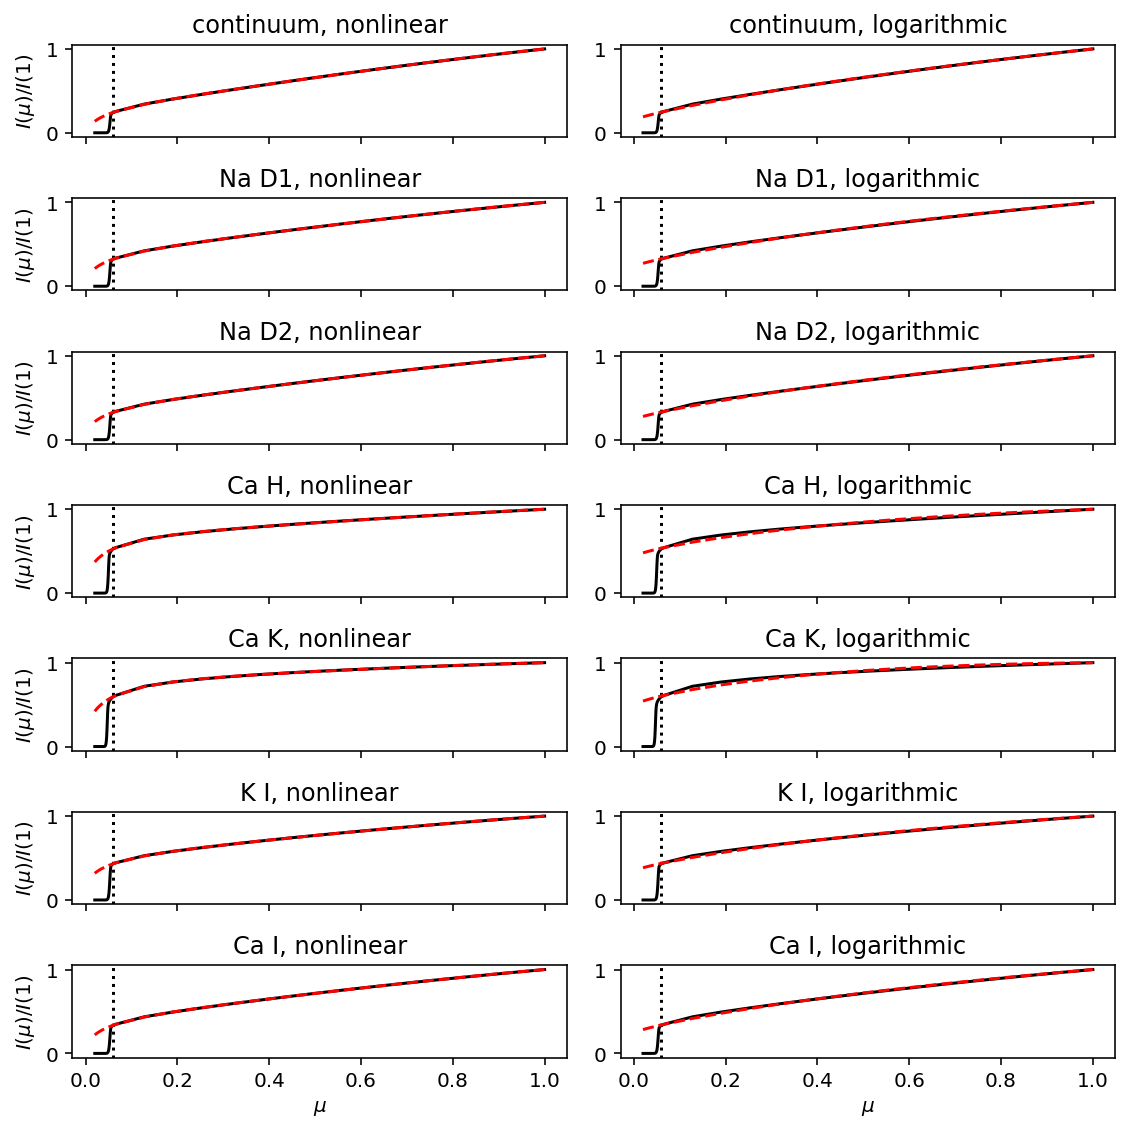

In [669]:
fig, ax = plt.subplots(len(test_wavelengths), 2, figsize=(8, 8), sharex=True)

for i, wl, label in zip(range(len(test_wavelengths)), test_wavelengths, wl_names):
    ind = np.argmin(np.abs(wavelengths - wl))
    
    for j in range(2):
        ax[i, j].plot(mu, mu_vs_lam[:, ind], 'k')
        ax[i, j].axvline(mu_lower_limit, ls=':', color='k')
    
    u_nl = wavelength_to_nonlinear(wl)
    ax[i, 0].plot(mu, nonlinear(u_nl, mu), 'r--')
    u_log = wavelength_to_log(wl)
    ax[i, 1].plot(mu, logarithmic(u_log, mu), 'r--')

    ax[i, 0].set_ylabel('$I(\mu)/I(1)$')
    
    ax[i, 0].set_title(label + ', nonlinear')
    ax[i, 1].set_title(label + ', logarithmic')
for j in range(2):
    ax[-1, j].set_xlabel('$\mu$')
#ax[-1, 0].set(xlabel='$\mu$', ylabel='$I(\mu)/I(1)$')
fig.tight_layout()

In [670]:
from astropy.constants import R_jup, R_sun

def hd189_wavelength_nl(u):
    hd189_params = batman.TransitParams()
    hd189_params.per = 2.21857567
    hd189_params.t0 = 2454279.436714
    hd189_params.inc = 85.7100
    hd189_params.a = 8.84
    hd189_params.rp = float((1.138 * R_jup)/(0.805 * R_sun))
    hd189_params.limb_dark = 'nonlinear'
    hd189_params.u = u
    hd189_params.ecc = 0
    hd189_params.w = 90
    return hd189_params

def wavelength_to_transit(times, wavelength):
    params = hd189_wavelength_nl(wavelength_to_nonlinear(wavelength))
    model = batman.TransitModel(params, times)
    f = model.light_curve(params)
    return f

def nl_to_transit(times, params):
    params = hd189_wavelength_nl(wavelength_to_nonlinear(wavelength))
    model = batman.TransitModel(params, times)
    f = model.light_curve(params)
    return f

def optical_to_transit(times):
    params = hd189_wavelength_nl(optical_to_nonlinear())
    model = batman.TransitModel(params, times)
    f = model.light_curve(params)
    return f

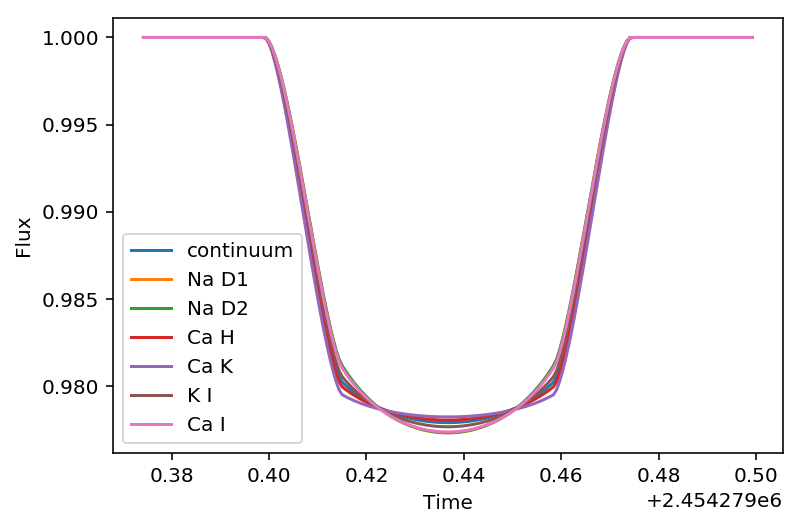

In [671]:
import astropy.units as u

times = params.t0 + np.linspace(-1.5/24, 1.5/24, 200)

for i, wl, label in zip(range(len(test_wavelengths)), test_wavelengths, wl_names):
    if label != 'continuum':
        f = wavelength_to_transit(times, wl)
    else: 
        f = optical_to_transit(times)

    plt.plot(times, f, label=label)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.savefig('plots/transit.png')

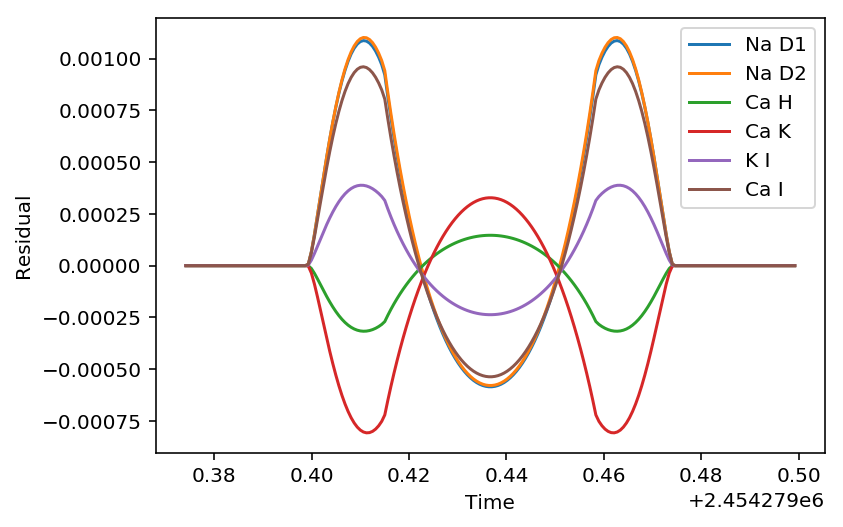

In [674]:
f_continuum = optical_to_transit(times)

for i, wl, label in zip(range(len(test_wavelengths)-1), test_wavelengths[1:], wl_names[1:]):
    f = wavelength_to_transit(times, wl)
    plt.plot(times, f - f_continuum, label=label)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend();
plt.savefig('plots/residuals.png', bbox_inches='tight', dpi=200)

***

In [675]:
mu = fits.open("data/lte04800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")[1].data
mu_vs_lam = fits.getdata("data/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")
mu_vs_lam /= mu_vs_lam.max(axis=0)

header = fits.getheader("data/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")

wavelengths = header['CRVAL1'] + np.arange(0, mu_vs_lam.shape[1]) * header['CDELT1']

one_minus_mu = 1 - mu

$R_{sim} = \frac{\lambda}{\Delta \lambda_{sim}}$ 

In [676]:
index_5000 = np.argmin(np.abs(wavelengths - 5000))
sim_dlam = (wavelengths[index_5000+1] - wavelengths[index_5000])
simulation_R = wavelengths[index_5000]/sim_dlam
goal_R = 50

def rebin_pixels(image, wavelength_grid, binning_factor=4):
    # Courtesy of J.F. Sebastian: http://stackoverflow.com/a/8090605
    if binning_factor == 1:
        return image

    new_shape = (image.shape[0], image.shape[1]/binning_factor)
    sh = (new_shape[0], image.shape[0]//new_shape[0], new_shape[1],
          image.shape[1]//new_shape[1])
    
    binned_image = image.reshape(sh).mean(-1).mean(1)
    binned_wavelengths = wavelength_grid.reshape(new_shape[1], 
                                                 image.shape[1]//new_shape[1]).mean(-1)
    return binned_image, binned_wavelengths

bin_factor = int(simulation_R/goal_R)

binned_mu_vs_lam, binned_wavelengths = rebin_pixels(mu_vs_lam, wavelengths, bin_factor)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [677]:
index_5000 = np.argmin(np.abs(binned_wavelengths - 5000))
binned_dlam = (binned_wavelengths[index_5000+1] - binned_wavelengths[index_5000])
binned_R = binned_wavelengths[index_5000]/binned_dlam
binned_R

50.494999999999997

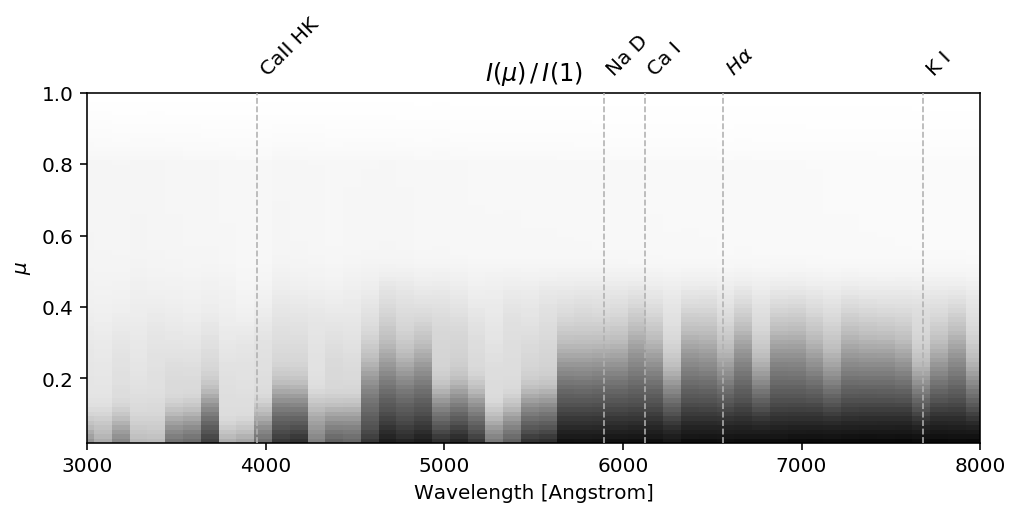

In [692]:
na_D = np.mean([5896, 5890])
ca_HK = np.mean([3968, 3934])
k_1 = np.mean([7664.8991, 7698.9645])
ca_1 = 6122.219
wl_names = ["Na D", "CaII HK", "K I", "Ca I", r"$H\alpha$"]
test_wavelengths = [na_D, ca_HK, k_1, ca_1, 6562.8]

extent = [binned_wavelengths.min(), binned_wavelengths.max(), 
          mu.min(), mu.max()]
          #one_minus_mu.max(), one_minus_mu.min()]
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(np.log(binned_mu_vs_lam), extent=extent, origin='lower', 
# ax.imshow(binned_mu_vs_lam, extent=extent, origin='lower', 
          interpolation='nearest', cmap=plt.cm.Greys_r)
ax.set_xlim([3000, 8000])
ax.set_aspect(2000)

ax2 = fig.add_axes(ax.get_position(), frameon=False)
ax2.tick_params(labelbottom='off',labeltop='on', 
                labelleft="off", labelright='off',
                bottom='off', left='off', right='off')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(test_wavelengths)
ax2.set_xticklabels(wl_names)
ax2.grid(axis='x', ls='--')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='left')

plt.draw()
ax2.set_position(ax.get_position())

ax.set(xlabel='Wavelength [Angstrom]', ylabel='$\mu$');
ax2.set_title("$I(\mu) \,/\, I(1)$")
fig.savefig('plots/intensity.png', bbox_inches='tight', dpi=200)

In [693]:
def hd189_vary_rp(rp, u):
    hd189_params = batman.TransitParams()
    hd189_params.per = 2.21857567
    hd189_params.t0 = 2454279.436714
    hd189_params.inc = 85.7100
    hd189_params.a = 8.84
    hd189_params.rp = rp #float((1.138 * R_jup)/(0.805 * R_sun))
    hd189_params.limb_dark = 'nonlinear'
    hd189_params.u = u
    hd189_params.ecc = 0
    hd189_params.w = 90
    return hd189_params

def transit_model(rp, times):
    params = hd189_vary_rp(rp, optical_mean_params)
    model = batman.TransitModel(params, times)
    f = model.light_curve(params)
    return f

def transit_chi2(p, times, data):
    rp = p[0]
    return np.sum((transit_model(rp, times) - data)**2/0.01**2)

def fit_transit(times, data, initp):
    return fmin_l_bfgs_b(transit_chi2, initp, args=(times, data), disp=0, 
                         approx_grad=True, bounds=[[0.05, 0.2]])

In [694]:
def chi2_nl_binned(p, mu, wl):
    limit_mu = mu > mu_lower_limit
    ind = np.argmin(np.abs(binned_wavelengths - wl))
    intensity = binned_mu_vs_lam[limit_mu, ind]
    return np.sum((nonlinear(p, mu[limit_mu]) - intensity)**2 / 0.01**2)

def wavelength_to_nonlinear_binned(wavelength):
    return fmin_slsqp(chi2_nl_binned, [0.5, -0.1, 0.1, -0.1], 
                      args=(mu, wavelength), disp=0)

def wavelength_to_transit_binned(times, wavelength):
    params = hd189_wavelength_nl(wavelength_to_nonlinear_binned(wavelength))
    model = batman.TransitModel(params, times)
    f = model.light_curve(params)
    return f

In [688]:
from astropy.utils.console import ProgressBar

fit_wavelengths = binned_wavelengths[((binned_wavelengths < 8500) & 
                                      (binned_wavelengths > 3000))]

initp = [float((1.138 * R_jup)/(0.805 * R_sun))]

radii = np.zeros_like(fit_wavelengths)
with ProgressBar(len(fit_wavelengths), ipython_widget=True) as bar:
    for i, wl in enumerate(fit_wavelengths):
        data = wavelength_to_transit_binned(times, wl)
        bestrp = fit_transit(times, data, initp)
        radii[i] = bestrp[0]
        bar.update()
    #model = transit_model(bestrp, times)
    #plt.plot(times, data)

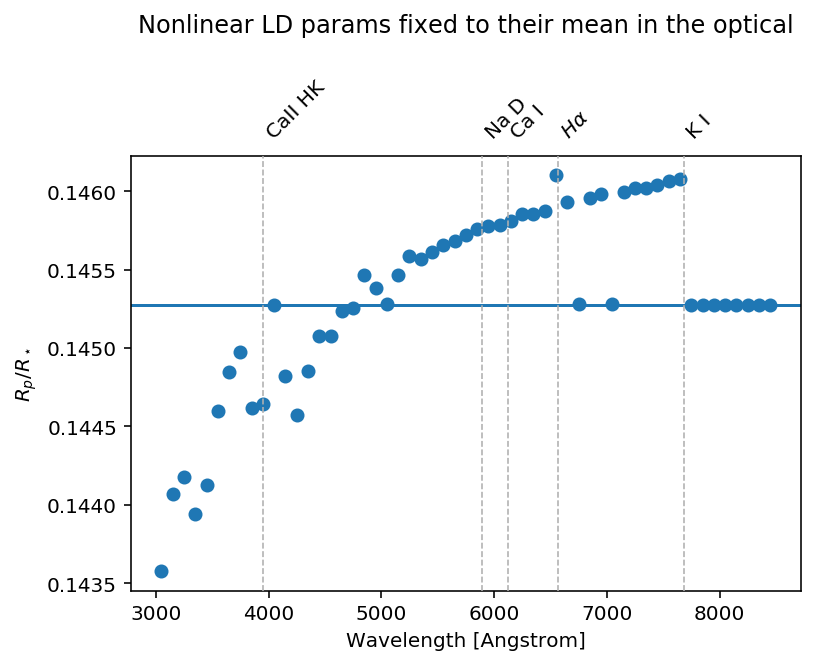

In [695]:
fig, ax = plt.subplots()
ax.plot(fit_wavelengths, radii, 'o')

ax.axhline(initp[0])
ax2 = fig.add_axes(ax.get_position(), frameon=False)
ax2.tick_params(labelbottom='off',labeltop='on', 
                labelleft="off", labelright='off',
                bottom='off', left='off', right='off')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(test_wavelengths)
ax2.set_xticklabels(wl_names)
ax2.grid(axis='x', ls='--')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='left')

ax.set_xlabel('Wavelength [Angstrom]')
ax.set_ylabel(r'$R_p/R_\star$')
ax.set_title('Nonlinear LD params fixed to their mean in the optical\n\n\n\n')
plt.savefig('plots/false_spectrum.png', bbox_inches='tight', dpi=200)